# Main Code

## 0. Setting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/object_image'

/content/drive/MyDrive/object_image


In [4]:
!ls

data  data.tar.gz  Main_Code.ipynb


In [5]:
#!tar -zcvf data.tar.gz data  

In [6]:
# !tar -xzf data.tar.gz

## 1. Data Load

In [7]:
from glob import glob
import os
import PIL
PIL.Image

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers, models
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from functools import partial

### 함수 및 상수 정의

In [8]:
# Data Load fuction Def
def load_CIFAR10(path):
    
    path = path
    images = []
    labels = []
    for filename in glob(path +"*"):
        for img in glob(filename + "/*.jpg"):
            an_img = PIL.Image.open(img) #read img
            img_array = np.array(an_img) #img to array
            images.append(img_array) #append array to training_images
            label = filename.split('/')[2] #get label
            labels.append(label) #append label
    images = np.array(images)
    labels = np.array(labels)

    le = LabelEncoder()
    labels= le.fit_transform(labels)
    labels = labels.reshape(-1,1)
    
    return images, labels, le

#create test dataset
def load_test(path):
    test_images = []
    test_idx = []

    flist = sorted(glob(path + '*.jpg'))

    for filename in flist:
        an_img = PIL.Image.open(filename) #read img
        img_array = np.array(an_img) #img to array
        test_images.append(img_array) #append array to training_images 
        
        label = filename.split('/')[2] #get id 
        test_idx.append(label) #append id
        
    test_images = np.array(test_images)

    print(test_images.shape)
    print(test_idx[0:5])
    return test_images

# Define image's format
class Default:
    imgR     = 32
    imgC     = 32
    channel  = 3
    imgCount = 5000
    
# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

In [9]:
path = 'data/train/'
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

### 데이터 불러오기

In [10]:
training_images, training_labels, le = load_CIFAR10(path=path)

In [11]:
test_images = load_test('data/test/')

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


## 2. EDA

In [12]:
print("train 이미지 크기:", training_images.shape)
print("train 라벨 크기:", training_labels.shape)
print('클래스 값:',np.unique(training_labels))

train 이미지 크기: (50000, 32, 32, 3)
train 라벨 크기: (50000, 1)
클래스 값: [0 1 2 3 4 5 6 7 8 9]


[[0 0 0 0 0 0 0 0 0 0]]


<Figure size 432x288 with 0 Axes>

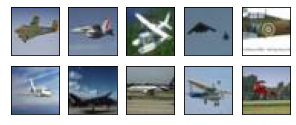

In [13]:
plot_images(2,5,training_images[:10])
print(training_labels[:10].reshape(1,-1))

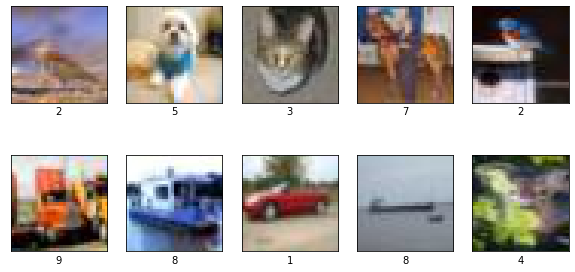

In [14]:
plt.figure(figsize=[10,5])
for i in range(10):
    import random
    num = random.randint(0,50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(training_labels[num][0])
    plt.imshow(training_images[num])
plt.show()

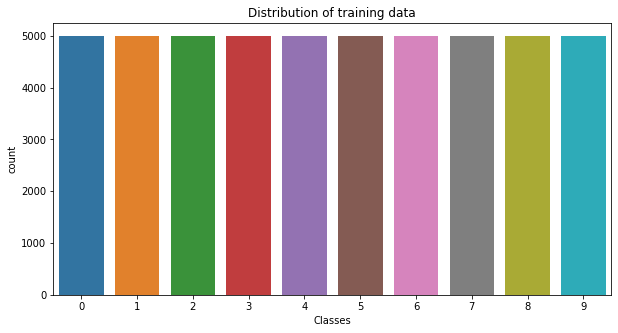

In [15]:
plt.figure(figsize=[10,5])
sns.countplot(training_labels.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## 3. Data Prepare & Preprocessing

### 데이터 증강

In [16]:
# ImageDataGenerator객체 정의
datagenerator = ImageDataGenerator(rotation_range = 30, brightness_range=[0.8,1.2], width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=False, vertical_flip=False, fill_mode='nearest')

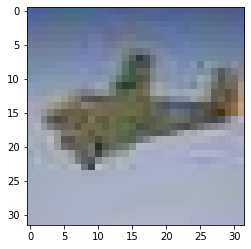

In [17]:
sample = training_images[0]
plt.imshow(sample)
sample = np.expand_dims(sample, 0)

In [18]:
sample_image_it = datagenerator.flow(sample, batch_size=1, seed = 42)

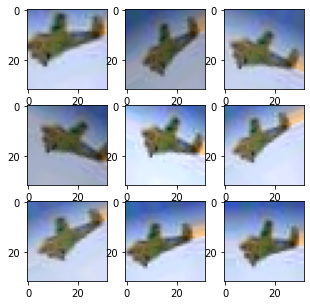

In [19]:
fig = plt.figure(figsize = (5,5))
for i in range(9):
    plt.subplot(3, 3, 1+i)
    batch = sample_image_it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [20]:
augment_size = 150000 

np.random.seed(42)
idx = np.random.randint(training_images.shape[0], size=augment_size)
print('augsize :',len(idx))
training_image_aug = training_images[idx].copy()
training_labels_aug = training_labels[idx].copy()

augsize : 150000


In [21]:
training_image_aug = datagenerator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image_aug)) #training에 생성한 데이터 추가
training_labels = np.concatenate((training_labels, training_labels_aug))
print('training_images :',training_images.shape)
print('training_labels :',training_labels.shape)

training_images : (200000, 32, 32, 3)
training_labels : (200000, 1)


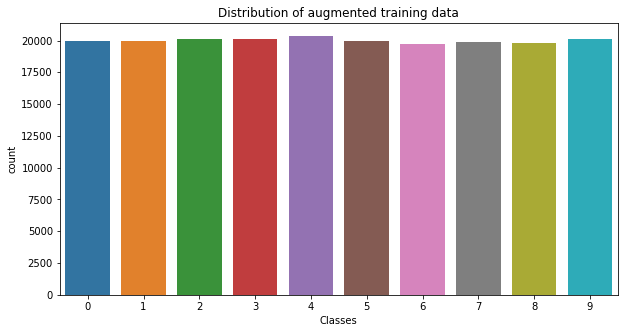

In [22]:
plt.figure(figsize=[10,5])
sns.countplot(training_labels.ravel())
plt.title('Distribution of augmented training data')
plt.xlabel('Classes')
plt.show()

### 데이터 분할

In [23]:
# 데이터 셔플
np.random.seed(25)
idx = np.arange(training_images.shape[0])
np.random.shuffle(idx)
training_images = training_images[idx]
training_labels = training_labels[idx]
idx

array([51960, 34873, 20655, ...,  6618, 90430, 29828])

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, random_state=42)
X_test = test_images

In [25]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test 크기:',X_test.shape)

X_train 크기: (160000, 32, 32, 3)
X_valid 크기: (40000, 32, 32, 3)
X_test 크기: (10000, 32, 32, 3)


In [26]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [27]:
print(X_train[0].mean())
print(X_valid[0].mean())
print(X_test[0].mean())

0.46949038
0.6659952
0.4291526245915032


## 4. CNN Model Design

ResNet 인공신경망 정의 Ver2

In [28]:
# Identity Block (항등 블럭) 정의
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

# Convolutional Bloack (컨볼루션 블럭) 정의
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [29]:
# ResNet2 모델 정의
def ResNet2(input_shape = (32, 32, 3), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = tf.keras.layers.Conv2D(64, (5,5), padding='SAME', strides=2)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = convolutional_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(10, activation = 'softmax')(X) # ouput layer (10 class)
    
    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet2")
    
    return model

In [30]:
# 모델 컴파일
model = ResNet2()
model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [31]:
# 가중치 정보 저장 경로
checkpoint_dir = path+'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# Checking the model summary
model.summary()

In [33]:
#!rm -rf Training_checkpoint/ # 가중치 저장 파일 전체 삭제

In [34]:
history = model.fit(X_train, y_train, batch_size=128, epochs=500,
                    callbacks=[early_stopping, cp],
                    validation_data = (X_valid,y_valid), verbose=0)


Epoch 1: val_loss improved from inf to 22.49224, saving model to data/train/Training_checkpoint/cp-0001-22.49.ckpt

Epoch 2: val_loss improved from 22.49224 to 21.53245, saving model to data/train/Training_checkpoint/cp-0002-21.53.ckpt

Epoch 3: val_loss improved from 21.53245 to 10.77007, saving model to data/train/Training_checkpoint/cp-0003-10.77.ckpt


KeyboardInterrupt: ignored

## 5. Learning Curve

Text(0.5, 1.0, 'Loss Curves')

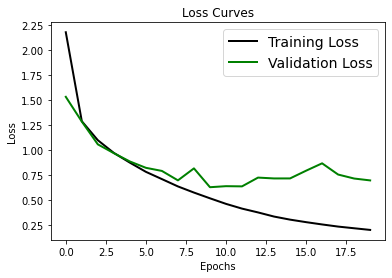

In [31]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

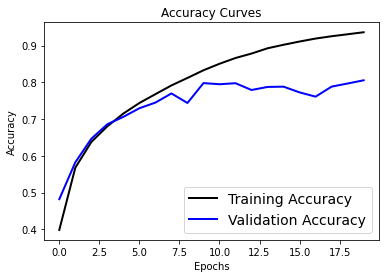

In [32]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## 6. Saving Model

In [ ]:
# 모델 저장
model.save('save/submit4model/')

INFO:tensorflow:Assets written to: save/submit3model/assets


In [ ]:
# history 파일로 저장
history_df = pd.DataFrame(history.history)

with open('save/submit4history.csv', mode='w') as hist_file:
    history_df.to_csv(hist_file)

## 7. Prediction Performance

In [ ]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'horse', 'bird'], dtype='<U10')

In [ ]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit4.csv",index=False)

In [ ]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,bird
